# Style generation with custom data

In [1]:
from fastai_old.text import *
import html
import spacy 

spacy.load('en')

We're going to grab out custom data from the directory data/custom, and also create a directory in which we'll store our trained language models, data/custom_lm.

In [2]:
DATA_PATH=Path('data/')
DATA_PATH.mkdir(exist_ok=True)

PATH = Path('data/custom')
PATH.mkdir(exist_ok=True)

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [3]:
LM_PATH=Path('data/custom_lm/')
LM_PATH.mkdir(exist_ok=True)

Now we're going to load data that is a single text file of plain text. We'll need to split the text into chunks for efficient training and to hold out some data as validation. We'll set a minimum chunk size, and otherwise break at paragraphs.

In [4]:
minwords = 100

def get_texts(fname):
    texts = []
    with fname.open('r', encoding='utf-8') as f:
        curr = ['', 0]
        for line in f:
            l = len(line.split(' '))
            if curr[1] + l > minwords:
                texts.append(curr[0])
                curr = [line, l]
            else:
                curr[0] += '\n' + line
                curr[1] += l
    if curr[0] != '':
        texts.append(curr[0])
    return np.array(texts)

all_texts = get_texts(PATH/'alice.txt')
len(all_texts)

301

In [5]:
random.choice(all_texts)

'she thought, and looked into its eyes again, to see if there were any\n\ntears.\n\n\n\nNo, there were no tears. ‘If you’re going to turn into a pig, my dear,’\n\nsaid Alice, seriously, ‘I’ll have nothing more to do with you. Mind\n\nnow!’ The poor little thing sobbed again (or grunted, it was impossible\n\nto say which), and they went on for some while in silence.\n\n\n\nAlice was just beginning to think to herself, ‘Now, what am I to do with\n\nthis creature when I get it home?’ when it grunted again, so violently,\n'

In [6]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    all_texts, test_size=0.3)

len(trn_texts), len(val_texts)

(210, 91)

In [7]:
col_names = ['text']
df_trn = pd.DataFrame({'text':trn_texts}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts}, columns=col_names)

In [8]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('.',' .').replace('?',' ?').replace('!',' !').replace('’'," '")
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
    texts = f'\n{BOS} {FLD} 1 ' + df['text'].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

tok_trn = get_texts(df_trn)
tok_val = get_texts(df_val) 

So I'm changing some stuff here from the IMDb tutorial: I want to keep all the vocab from the pre-trained language model, so I union the vocab of the custom data and the pre-trained model.

This is partially because I think that makes sense and is cool -- the custom data has a very small vocab (alice.txt is only 1k unique works, I think) but also because I ran into an error when finding the learning rate in which it couldn't normalize because it was all 0s... so maybe having the whole vocab will fix that? We'll see.

In [14]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(8)

[(',', 1672),
 ('the', 1159),
 ("'", 1030),
 ('\n\n', 919),
 ('‘', 795),
 ('.', 692),
 ('and', 564),
 ('to', 519)]

Experimenting with using pre-trained vocab, versus style vocab, versus something in the middle.

In [18]:
max_vocab = 60000
min_freq = 1

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

PRE_PATH = Path('data/aclImdb/models/wt103')
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

# itos = list(set(itos).union(itos2))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

with open(LM_PATH/'itos_alice.pkl', 'wb') as f:
    pickle.dump(itos, f)

vs=len(itos)
vs

1199

In [19]:
len(itos2)

238462

In [20]:
len(freq.most_common(max_vocab))

2238

In [21]:
len(itos2)

238462

In [22]:
em_sz,nh,nl = 400,1150,3

wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):                     # for word in imbd vocab
    r = stoi2[w]                                # get the int in the pretrained vocab
    new_w[i] = enc_wgts[r] if r>=0 else row_m   # add weight if in vocab, else add mean weight
    
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.model.load_state_dict(wgts)

In [39]:
def generate_text(m, s, l=20):
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi[w] for w in ss]
    t = torch.autograd.Variable(torch.cuda.LongTensor(np.array([si])))
    
    res,*_ = m(t)

    print(s,"\n")
    for i in range(l):
#         n = res[-1].topk(2)[1]
        n = torch.multinomial(res[-1].exp(), 2)
        n = n[1] if n.data[0]==0 else n[0]
        print(itos[n], end=' ')
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))
    print('...')

In [24]:
m=learner.model

In [26]:
generate_text(m, "The movie was")

The movie was 

not only the first of the two , but the first of the two . the second was the first ...


In [27]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

lr=1e-3
lrs = lr

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy               
    0      5.037357   4.910271   0.191998  



[4.910271167755127, 0.19199849665164948]

In [31]:
wd,lrs

(1e-07, 0.001)

In [30]:
learner.save('alice_lm_last_ft')

In [32]:
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy               
    0      4.523354   3.805279   0.273335  



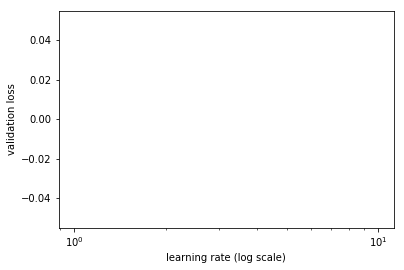

In [33]:
learner.sched.plot()

In [34]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=5)

epoch      trn_loss   val_loss   accuracy               
    0      4.745263   4.086333   0.255122  
    1      4.364309   3.848019   0.283668               
    2      4.152079   3.705238   0.29208                
    3      3.9936     3.663283   0.29829                
    4      3.883581   3.638629   0.297665               



[3.6386290788650513, 0.2976648360490799]

In [35]:
learner.save('alice_lm_5epochs')

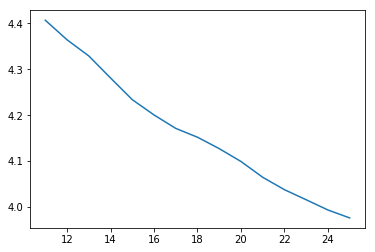

In [36]:
learner.sched.plot_loss()

In [40]:
generate_text(m, "The movie was", l=100)

The movie was 

written by the general thoroughly , the man was almost nearly confused where his majesty was doing . their size could not be grown up . they were on the side of the stairs for another 1 m to the great passage . their bottom was broken crowded down into an cauldron ; some were tiny wink like flamingo , by means of noise , or with a broken line ; these faces were so large that timid and sometimes , they were low , but they were even chorus . her youth and ready majesty were frightened to use ...


In [41]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=5)

epoch      trn_loss   val_loss   accuracy               
    0      3.501084   3.580699   0.302077  
    1      3.381549   3.542558   0.302031               
    2      3.271162   3.510732   0.310945               
    3      3.176434   3.479581   0.311102               
    4      3.109201   3.474447   0.312453               



[3.474447011947632, 0.31245261430740356]

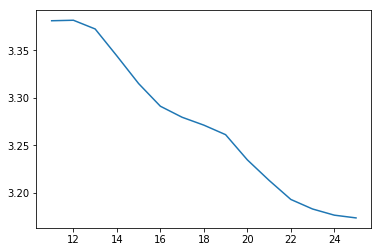

In [42]:
learner.sched.plot_loss()

epoch      trn_loss   val_loss   accuracy               
    0      2.868436   3.489471   0.309443  
    1      2.755958   3.505237   0.30879                
    2      2.704693   3.522861   0.307067               
    3      2.654822   3.482831   0.314858               
    4      2.589235   3.498933   0.309661               



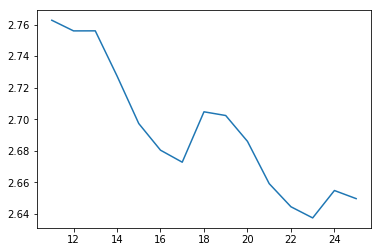

In [46]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=5)
learner.sched.plot_loss()

In [47]:
generate_text(m, "She was", l=100)

She was 

the next door was set to open . there were twelve doors between them . there were twenty - three doors opened , four easy doors that keep out low after a alarm . the door closed and the door closed . only the door was open , and the doors were closed . when one of the doors door was shut for a moment , it led into a little room which had been closed for a moment . she lived at the top of the chimney , and knew where to go ! this was before her eyes ...


In [45]:
generate_text(m, "She was", l=100)

She was 

a day after she was learnt that her hair had been rubbing perfectly against her . she looked up and cried “ she ringlets ! ” this time , she fell asleep , ‘ , and the jurors all went mad with earth ; so she couldn ' t swim till the jurors first began muttering ; ‘ however , what was the use of her name in the book , ? ' 


 
 xbos xfld 1 nearly another eye , as she began looking at her face , soo croquet soon afterwards , and its eyes were very ...
